In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA
import pickle
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'          # use the generic “serif” family
# (optional) tell matplotlib which concrete serif faces you prefer, in priority order:
mpl.rcParams['font.serif'] = ['Times New Roman', 'STIXGeneral', 'DejaVu Serif']

mpl.rcParams['mathtext.fontset'] = 'cm'


def generate_data(n_inliers=100, n_outliers=20, d=3):
   
    
    
    D = d + 1

    
    A = np.random.randn(D, D)
    A1 = np.random.randn(D, D)
    Q, _ = np.linalg.qr(A)
    Q1, _ = np.linalg.qr(A1)

    
    P_inlier = Q[:, :d]  # shape: (D, d)
    P_orth = Q1[:,1:]
    P_outlier = Q1[:, d]  # shape: (D,)

   
    inliers = np.random.randn(n_inliers, d)
    inliers_embedded = inliers @ P_inlier.T

    
    outliers = np.random.randn(n_outliers, 1)
    #noise = np.random.randn(n_outliers,1)
    #outliers = outliers + 0*noise
    outliers_embedded = outliers @ P_outlier.reshape(1, -1)

    
    data = np.concatenate([inliers_embedded, outliers_embedded], axis=0)

    
    norms = np.linalg.norm(data, axis=1, keepdims=True)
    data_normalized = data / norms

    return data_normalized, P_inlier,P_orth

In [5]:
def FMS_small(X, dd,L0):
    
    D, N = X.shape
    iter_count = 1
    tol=1e-12 
    max_iter=200

  
    L = L0
    # Dictionary to store intermediate L values at every iteration
    L_intermediate = {}


    for iter_count in range(1, max_iter + 1):
        L_old = L.copy()

        residual = (np.eye(D) - L @ L.T) @ X

        w = np.maximum(1e-10, np.sqrt(np.sum(residual**2, axis=0)))

        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T

        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        ang = np.linalg.norm(subspace_angles(L, L_old))

        # Store L at the current iteration
        L_intermediate[iter_count] = L.copy()


    return L, L_intermediate

def FMS_large(X, dd,L0):
    
    D, N = X.shape
    iter_count = 1
    tol=1e-12 
    max_iter=200

    
    L = L0

    L_intermediate = {}

    
    ang = 1

    for iter_count in range(1, max_iter + 1):
        L_old = L.copy()

        # Residual projection onto the orthogonal complement of L
        residual = (np.eye(D) - L @ L.T) @ X

        # Compute weights with a small regularization
        w = np.maximum(1e-3, np.sqrt(np.sum(residual**2, axis=0)))


        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T

        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        # Compute convergence metric using your subspace_angles function
        ang = np.linalg.norm(subspace_angles(L, L_old))

        L_intermediate[iter_count] = L.copy()

        iter_count += 1

    return L, L_intermediate

def FMS_dc(X, dd,gamma,L0):
    
    D, N = X.shape
    iter_count = 1
    tol=1e-12 
    max_iter=200
    total_epsilon = []
    
    L = L0


    residual = (np.eye(D) - L @ L.T) @ X
    distances = np.sqrt(np.sum(residual**2, axis=0))
    epsilon0 = np.quantile(distances, gamma)
    total_epsilon.append(epsilon0)

    L_intermediate = {}
    

 
    ang = 1

    for iter_count in range(1, max_iter + 1):
        L_old = L

        # Residual projection onto the orthogonal complement of L
        residual = (np.eye(D) - L_old @ L_old.T) @ X
        distances = np.sqrt(np.sum(residual**2, axis=0))
        
        # Update smoothing parameter: dynamic update based on the gamma-th quantile.
        q_gamma_val = np.quantile(distances, gamma)
        epsilon = min(epsilon0, q_gamma_val)
        total_epsilon.append(epsilon)
        
        w = np.maximum(epsilon, distances)
       
        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T

        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        # Compute convergence metric using your subspace_angles function
        ang = np.linalg.norm(subspace_angles(L, L_old))

        L_intermediate[iter_count] = L.copy()

        iter_count += 1

    return L, L_intermediate,total_epsilon
# return the epsilon of FMS_ds,

def FMS_ex(X, dd,L0):
    
    D, N = X.shape
    iter_count = 1
    tol=1e-12 
    max_iter=200

  
    L = L0
    # Dictionary to store intermediate L values at every iteration
    L_intermediate = {}


    for iter_count in range(1, max_iter + 1):
        L_old = L.copy()

        residual = (np.eye(D) - L @ L.T) @ X

        w = np.maximum(1e-15, np.sqrt(np.sum(residual**2, axis=0)))

        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T

        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        ang = np.linalg.norm(subspace_angles(L, L_old))

        # Store L at the current iteration
        L_intermediate[iter_count] = L.copy()


    return L, L_intermediate




np.random.seed(123)
repeats = 100
d = 3
total_points = 200

outlier_percents = np.arange(2, 40, 2) 
avg_errors_small = {}
avg_errors_large = {}
avg_errors_dc = {}


for pct in outlier_percents:
    num2 = int(total_points * pct / 100)              # number of outliers
    num1 = total_points - num2                        # number of inliers

    errors_small = []
    errors_large = []
    errors_dc = []

    gamma = 0.5
    for trial in range(repeats):
        
        data, P_true, P_orth = generate_data(n_inliers=num1, n_outliers=num2, d=d)
        L0 = P_orth



        # FMS_small 
        P_small, L_small = FMS_small(data.T, d,L0)
        # FMS_large 
        P_large, L_large = FMS_large(data.T, d,L0)
        # FMS_dc 
        P_dc, L_dc,_ = FMS_dc(data.T, d, gamma,L0)
        
        
        error_small = np.linalg.norm(P_small @ P_small.T - P_true @ P_true.T)
        error_large = np.linalg.norm(P_large @ P_large.T - P_true @ P_true.T)
        error_dc    = np.linalg.norm(P_dc @ P_dc.T - P_true @ P_true.T)
        
        
        errors_small.append(error_small)
        errors_large.append(error_large)
        errors_dc.append(error_dc)
    
    
    avg_errors_small[pct] = np.mean(errors_small)
    avg_errors_large[pct] = np.mean(errors_large)
    avg_errors_dc[pct]    = np.mean(errors_dc)
    med_small[pct] = np.median(errors_small)          
    med_large[pct] = np.median(errors_large)          
    med_dc[pct]    = np.median(errors_dc)             

    
    #print(f"\nFor {num2} outliers:")
    #print("Average FMS_small error:", avg_errors_small[num2])
    #print("Average FMS_large error:", avg_errors_large[num2])
    #print("Average FMS_dc error:",    avg_errors_dc[num2])
sorted_pcts = sorted(avg_errors_small.keys())
avg_small   = [avg_errors_small[x] for x in sorted_pcts]
avg_large   = [avg_errors_large[x] for x in sorted_pcts]
avg_dc      = [avg_errors_dc[x] for x in sorted_pcts]

results_exp2 = {
    "outlier_pcts"   : sorted_pcts,
    "avg_errors_small": [avg_small[p] for p in sorted_pcts],
    "avg_errors_large": [avg_large[p] for p in sorted_pcts],
    "avg_errors_dc"   : [avg_dc[p]    for p in sorted_pcts],
    "med_errors_small": [med_small[p] for p in sorted_pcts],   # NEW
    "med_errors_large": [med_large[p] for p in sorted_pcts],   # NEW
    "med_errors_dc"   : [med_dc[p]    for p in sorted_pcts]    # NEW
}


with open('exp2_errors_d3.pkl', 'wb') as f:
    pickle.dump(results_exp2, f)



In [6]:


np.random.seed(123)
repeats      = 100
d            = 3
total_points = 200
outlier_pcts = np.arange(2, 40, 2)

# --- containers ------------------------------------------------------------
errors_small = []
errors_large = []
errors_dc1   = []
errors_dc2   = []
errors_ex    = []

for pct in outlier_pcts:
    n_out = int(total_points * pct / 100)
    n_in  = total_points - n_out

    trial_small, trial_large = [], []
    trial_dc1, trial_dc2     = [], []
    trial_ex                 = []

    for _ in range(repeats):
        data, P_true, P_orth = generate_data(n_inliers=n_in, n_outliers=n_out, d=d)
        L0 = P_orth

        # Run subspace recovery methods
        P_s, _     = FMS_small(data.T, d, L0)
        P_l, _     = FMS_large(data.T, d, L0)
        P_d1, _, _ = FMS_dc(data.T, d, 0.5, L0)
        P_d2, _, _ = FMS_dc(data.T, d, 0.1, L0)
        P_e, _     = FMS_ex(data.T, d, L0)

        # Compute subspace error: ||P P^T - P_true P_true^T||_F
        trial_small.append(np.linalg.norm(P_s @ P_s.T - P_true @ P_true.T))
        trial_large.append(np.linalg.norm(P_l @ P_l.T - P_true @ P_true.T))
        trial_dc1.append(np.linalg.norm(P_d1 @ P_d1.T - P_true @ P_true.T))
        trial_dc2.append(np.linalg.norm(P_d2 @ P_d2.T - P_true @ P_true.T))
        trial_ex. append(np.linalg.norm(P_e @ P_e.T - P_true @ P_true.T))

    # Append results for each outlier level
    errors_small.append(trial_small)
    errors_large.append(trial_large)
    errors_dc1. append(trial_dc1)
    errors_dc2. append(trial_dc2)
    errors_ex.  append(trial_ex)

# Convert to NumPy arrays for slicing/plotting
errors_small = np.array(errors_small)
errors_large = np.array(errors_large)
errors_dc1   = np.array(errors_dc1)
errors_dc2   = np.array(errors_dc2)
errors_ex    = np.array(errors_ex)

# Save result dictionary
results_exp2 = {
    "outlier_pcts" : outlier_pcts,
    "errors_small" : errors_small,
    "errors_large" : errors_large,
    "errors_dc"    : errors_dc1,
    "errors_dc2"   : errors_dc2,
    "errors_ex"    : errors_ex
}

with open(f'exp2_errors_d{d}.pkl', "wb") as f:
    pickle.dump(results_exp2, f)


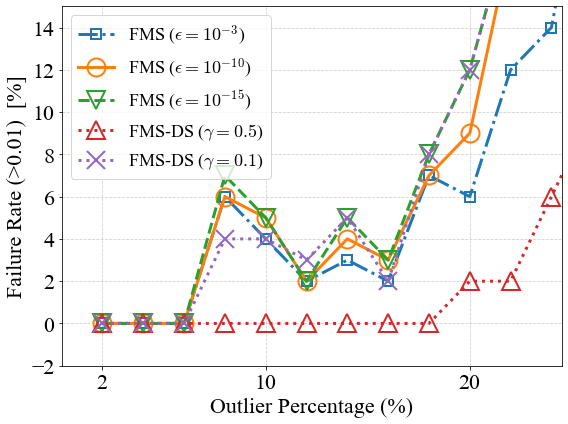

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# Load data
d = 3  # Add this if not already defined
with open(f'exp2_errors_d{d}.pkl', "rb") as f:
    r = pickle.load(f)

# Extract
pcts       = r["outlier_pcts"]
errs_small = r["errors_small"]
errs_large = r["errors_large"]
errs_dc1   = r["errors_dc"]
errs_dc2   = r["errors_dc2"]
errs_ex    = r["errors_ex"]

threshold = 1e-2

def failure_rate(errs):
    return (errs > threshold).mean(axis=1) * 100  # percentage

fail_small = failure_rate(errs_small)
fail_large = failure_rate(errs_large)
fail_dc1   = failure_rate(errs_dc1)
fail_dc2   = failure_rate(errs_dc2)
fail_ex    = failure_rate(errs_ex)

# ------------------ Plotting ------------------
plt.figure(figsize=(8, 6))
#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.plot(pcts, fail_large, 's-.',  linewidth=3, markersize=10,
         markeredgewidth=2, fillstyle='none', label='FMS ($\\epsilon=10^{-3}$)')
plt.plot(pcts, fail_small, 'o-',   linewidth=3, markersize=18,
         markeredgewidth=2, fillstyle='none', label='FMS ($\\epsilon=10^{-10}$)')
plt.plot(pcts, fail_ex,    'v--',  linewidth=3, markersize=18,
         markeredgewidth=2, fillstyle='none', label='FMS ($\\epsilon=10^{-15}$)')

plt.plot(pcts, fail_dc1,   '^:',   linewidth=3, markersize=18,
         markeredgewidth=2, fillstyle='none', label='FMS-DS ($\\gamma=0.5$)')
plt.plot(pcts, fail_dc2,   'x:',   linewidth=3, markersize=18,
         markeredgewidth=2, fillstyle='none', label='FMS-DS ($\\gamma=0.1$)')

plt.xlabel('Outlier Percentage (%)', fontsize=22)
plt.ylabel(f'Failure Rate (>%g)  [%%]' % threshold, fontsize=22)
plt.xticks([2, 10, 20, 30, 38], fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0, 24.5)
plt.ylim(-2, 15)
plt.grid(True, ls='--', alpha=0.6)
plt.legend(fontsize=18, frameon=True)
plt.tight_layout()
plt.savefig('exp2_failurerate2.png', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
count = np.sum(errs_small[11] > 1e-3)

print("Number of elements greater than 10^-3:", count)


Number of elements greater than 10^-3: 17


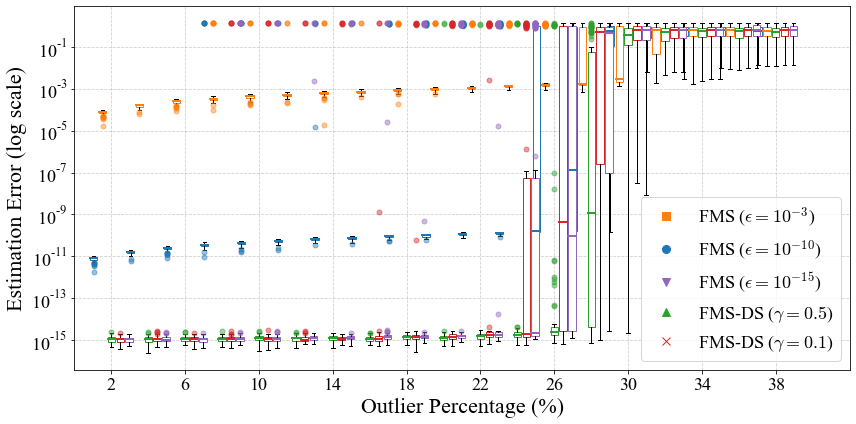

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(12, 6))

# ---- box positions -------------------------------------------------
w   = 0.4
gap = w * 1.2
pos_small = pcts - 2 * gap
pos_large = pcts - gap
pos_dc1   = pcts
pos_dc2   = pcts + gap
pos_ex    = pcts + 2 * gap

# ---- prepare data lists --------------------------------------------
data_small = [errs_small[i] for i in range(errs_small.shape[0])]
data_large = [errs_large[i] for i in range(errs_large.shape[0])]
data_dc1   = [errs_dc1[i]   for i in range(errs_dc1.shape[0])]
data_dc2   = [errs_dc2[i]   for i in range(errs_dc2.shape[0])]
data_ex    = [errs_ex[i]    for i in range(errs_ex.shape[0])]

# ---- color palette -------------------------------------------------
palette    = ['C0', 'C1', 'C2', 'C3', 'C4']
flier_kw   = lambda c: dict(marker='o', markersize=5, markerfacecolor=c, markeredgecolor=c, alpha=0.45)
median_kw  = lambda c: dict(color=c, linewidth=2)
common_box_kw = dict(widths=w, patch_artist=True, showfliers=True)

# ---- draw box plots ------------------------------------------------
ax.boxplot(data_small, positions=pos_small,
           boxprops=dict(facecolor='white', edgecolor=palette[0]),
           flierprops=flier_kw(palette[0]),
           medianprops=median_kw(palette[0]),
           **common_box_kw)

ax.boxplot(data_large, positions=pos_large,
           boxprops=dict(facecolor='white', edgecolor=palette[1]),
           flierprops=flier_kw(palette[1]),
           medianprops=median_kw(palette[1]),
           **common_box_kw)

ax.boxplot(data_dc1, positions=pos_dc1,
           boxprops=dict(facecolor='white', edgecolor=palette[2]),
           flierprops=flier_kw(palette[2]),
           medianprops=median_kw(palette[2]),
           **common_box_kw)

ax.boxplot(data_dc2, positions=pos_dc2,
           boxprops=dict(facecolor='white', edgecolor=palette[3]),
           flierprops=flier_kw(palette[3]),
           medianprops=median_kw(palette[3]),
           **common_box_kw)

ax.boxplot(data_ex, positions=pos_ex,
           boxprops=dict(facecolor='white', edgecolor=palette[4]),
           flierprops=flier_kw(palette[4]),
           medianprops=median_kw(palette[4]),
           **common_box_kw)

# ---- axis formatting -----------------------------------------------
ax.set_xlabel('Outlier Percentage (%)', fontsize=22)
ax.set_ylabel('Estimation Error (log scale)', fontsize=22)
ax.set_yscale('log')
ax.set_xticks(np.arange(2, 41, 4))
ax.set_xlim(0, 42)
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.tick_params(axis='both', labelsize=18)

# ---- legend --------------------------------------------------------
handles = [
    Line2D([], [], linestyle='', marker='s', color=palette[1], markersize=8, label='FMS ($\\epsilon=10^{-3}$)'),
    Line2D([], [], linestyle='', marker='o', color=palette[0], markersize=8, label='FMS ($\\epsilon=10^{-10}$)'),
    
    Line2D([], [], linestyle='',marker='v',   color=palette[4], markersize=8, label='FMS ($\\epsilon=10^{-15}$)'),
    Line2D([], [], linestyle='',marker='^',  color=palette[2], markersize=8, label='FMS-DS ($\\gamma=0.5$)'),
    Line2D([], [], linestyle='',marker='x',  color=palette[3], markersize=8, label='FMS-DS ($\\gamma=0.1$)')
]
ax.legend(handles=handles,  fontsize=18)

# ---- final touches -------------------------------------------------
ax.grid(True, which='both', ls='--', alpha=0.6)
fig.tight_layout()
plt.savefig('exp2_box2.png', dpi=300, bbox_inches='tight')
plt.show()


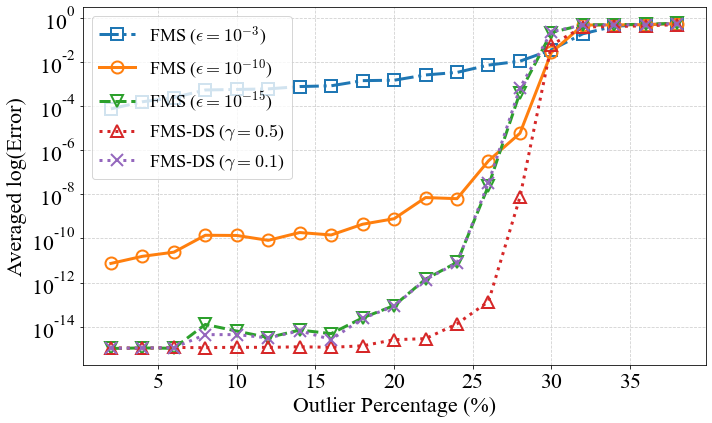

In [6]:
from scipy.stats import gmean


# Compute geometric means across trials
geo_sm  = gmean(errs_small, axis=1)
geo_lg  = gmean(errs_large, axis=1)
geo_dc1 = gmean(errs_dc1, axis=1)
geo_dc2 = gmean(errs_dc2, axis=1)
geo_ex  = gmean(errs_ex, axis=1)

plt.figure(figsize=(10, 6))

# Plot each method
plt.plot(pcts, geo_lg,  's-.', fillstyle='none', linewidth=3, markersize=12,
         markeredgewidth=2, label='FMS ($\\epsilon=10^{-3}$)')
plt.plot(pcts, geo_sm,  'o-', fillstyle='none', linewidth=3, markersize=12,
         markeredgewidth=2, label='FMS ($\\epsilon=10^{-10}$)')
plt.plot(pcts, geo_ex,  'v--', fillstyle='none', linewidth=3, markersize=12,
         markeredgewidth=2, label='FMS ($\\epsilon=10^{-15}$)')


plt.plot(pcts, geo_dc1, '^:', fillstyle='none', linewidth=3, markersize=12,
         markeredgewidth=2, label='FMS-DS ($\\gamma=0.5$)')
plt.plot(pcts, geo_dc2, 'x:', fillstyle='none', linewidth=3, markersize=12,
         markeredgewidth=2, label='FMS-DS ($\\gamma=0.1$)')

# Plot formatting
plt.xlabel("Outlier Percentage (%)", fontsize=22)
plt.ylabel("Averaged log(Error)", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.yscale("log")
plt.legend(loc='upper left', fontsize=18, frameon=True)
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()

# Save and show
plt.savefig('exp2_gmean.png', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10, 6))

#with open('exp2_errors_d3.pkl', 'rb') as f:
#    results_exp2 = pickle.load(f)



plt.plot(pcts, med_sm, marker='o',linewidth=3, markersize=8, label='FMS ($\\epsilon=10^{-10}$)')
plt.plot(pcts, med_lg, marker='s',linewidth=3, markersize=8, label='FMS ($\\epsilon=10^{-3}$)')
plt.plot(pcts, med_dc, marker='^',linewidth=3, markersize=8, label='FMS-DS')

plt.xlabel("Outlier Percentage (%)",fontsize=22)
plt.ylabel("Estimation Error (log scale)",fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.legend(loc='lower right', fontsize=22, frameon=True)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig('exp2_median.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
plt.figure(figsize=(10, 6))




plt.plot(pcts, avg_sm, marker='o',linewidth=3, markersize=8, label='FMS($\\epsilon=10^{-10}$)')
plt.plot(pcts, avg_lg, marker='s',linewidth=3, markersize=8, label='FMS($\\epsilon=10^{-3}$)')
plt.plot(pcts, avg_dc, marker='^',linewidth=3, markersize=8, label='FMS-DS')

plt.xlabel("Outlier Percentage (%)",fontsize=16)
plt.ylabel("Estimation Error(log scale)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.legend(loc='lower right', fontsize=16, frameon=True)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig('exp2.png', dpi=300, bbox_inches='tight')
plt.show()


NameError: name 'avg_sm' is not defined

<Figure size 720x432 with 0 Axes>

np.random.seed(123)
repeats = 100
d = 3
total_points = 200

outlier_percents = np.arange(2, 25, 1) 
avg_errors_small = {}
avg_errors_large = {}
avg_errors_dc = {}


for pct in outlier_percents:
    num2 = int(total_points * pct / 100)              # number of outliers
    num1 = total_points - num2                        # number of inliers

    errors_small = []
    errors_large = []
    errors_dc = []

    gamma = 0.5
    for trial in range(repeats):
        
        data, P_true, P_orth = generate_data(n_inliers=num1, n_outliers=num2, d=d)
        L0 = P_orth



        # FMS_small 
        P_small, L_small = FMS_small(data.T, d,L0)
        # FMS_large 
        P_large, L_large = FMS_large(data.T, d,L0)
        # FMS_dc 
        P_dc, L_dc,_ = FMS_dc(data.T, d, gamma,L0)
        
        
        error_small = np.linalg.norm(P_small @ P_small.T - P_true @ P_true.T)
        error_large = np.linalg.norm(P_large @ P_large.T - P_true @ P_true.T)
        error_dc    = np.linalg.norm(P_dc @ P_dc.T - P_true @ P_true.T)
        
        
        errors_small.append(error_small)
        errors_large.append(error_large)
        errors_dc.append(error_dc)
    
    
    avg_errors_small[pct] = np.mean(errors_small)
    avg_errors_large[pct] = np.mean(errors_large)
    avg_errors_dc[pct]    = np.mean(errors_dc)
    med_small[pct] = np.median(errors_small)          
    med_large[pct] = np.median(errors_large)          
    med_dc[pct]    = np.median(errors_dc)  

    
    #print(f"\nFor {num2} outliers:")
    #print("Average FMS_small error:", avg_errors_small[num2])
    #print("Average FMS_large error:", avg_errors_large[num2])
    #print("Average FMS_dc error:",    avg_errors_dc[num2])


# Prepare and save results
sorted_pcts = sorted(avg_errors_small.keys())
avg_small   = [avg_errors_small[x] for x in sorted_pcts]
avg_large   = [avg_errors_large[x] for x in sorted_pcts]
avg_dc      = [avg_errors_dc[x] for x in sorted_pcts]

results_exp2_zoom = {
    "outlier_pcts": sorted_pcts,
    "avg_errors_small": avg_small,
    "avg_errors_large": avg_large,
    "avg_errors_dc": avg_dc
}

# Save to file
with open('exp2_errors_d3_zoom.pkl', 'wb') as f:
    pickle.dump(results_exp2_zoom, f)




In [ ]:


np.random.seed(234)
repeats      = 100
d            = 3
total_points = 200
outlier_pcts = np.arange(10, 25, 1)

# --- containers ------------------------------------------------------------
errors_small = []     # list of lists  -> later shape (n_pcts, repeats)
errors_large = []
errors_dc    = []

for pct in outlier_pcts:
    n_out = int(total_points * pct / 100)
    n_in  = total_points - n_out

    trial_small, trial_large, trial_dc = [], [], []

    gamma = 0.5
    for _ in range(repeats):
        data, P_true, P_orth = generate_data(n_inliers=n_in,
                                             n_outliers=n_out, d=d)
        L0 = P_orth

        P_s, _ = FMS_small(data.T, d, L0)
        P_l, _ = FMS_large(data.T, d, L0)
        P_d, _, _ = FMS_dc(   data.T, d, gamma, L0)

        trial_small.append(np.linalg.norm(P_s @ P_s.T - P_true @ P_true.T))
        trial_large.append(np.linalg.norm(P_l @ P_l.T - P_true @ P_true.T))
        trial_dc.  append(np.linalg.norm(P_d @ P_d.T - P_true @ P_true.T))

    errors_small.append(trial_small)
    errors_large.append(trial_large)
    errors_dc.   append(trial_dc)

# convert to NumPy for easy slicing: shape = (n_pcts, repeats)
errors_small = np.asarray(errors_small)
errors_large = np.asarray(errors_large)
errors_dc    = np.asarray(errors_dc)

results_exp2_zoom = {
    "outlier_pcts" : outlier_pcts,        # shape (n_pcts,)
    "errors_small" : errors_small,        # raw 2-D data
    "errors_large" : errors_large,
    "errors_dc"    : errors_dc
}

with open("exp2_errors_d3_zoom.pkl", "wb") as f:
    pickle.dump(results_exp2_zoom, f)



In [ ]:

with open("exp2_errors_d3_zoom.pkl", "rb") as f:
    r = pickle.load(f)

pcts          = r["outlier_pcts"]
errs_small    = r["errors_small"]  
errs_large    = r["errors_large"]
errs_dc       = r["errors_dc"]

# 1⃣  median & mean per outlier level
med_sm = np.median(errs_small, axis=1)
avg_sm = np.mean(  errs_small, axis=1)
med_lg = np.median(errs_large, axis=1)
avg_lg = np.mean(errs_large,axis=1)
med_dc = np.median(errs_dc,    axis=1)
avg_dc = np.mean(errs_dc,axis=1)
 


In [ ]:
plt.figure(figsize=(10, 6))





plt.plot(pcts, med_sm, marker='o',linewidth=3, markersize=8, label='FMS($\\epsilon=10^{-10}$)')
plt.plot(pcts, med_lg, marker='s',linewidth=3, markersize=8, label='FMS($\\epsilon=10^{-3}$)')
plt.plot(pcts, med_dc, marker='^',linewidth=3, markersize=8, label='FMS-DS')

plt.xlabel("Outlier Percentage (%)",fontsize=16)
plt.ylabel("Estimation Error(log scale)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.legend(loc='lower right', fontsize=16, frameon=True)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig('exp2_median_zoom.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:


np.random.seed(123)
repeats      = 100
d            = 3
total_points = 200
outlier_pcts = np.arange(10, 25, 1)

# --- containers ------------------------------------------------------------
errors_small = []     # list of lists  -> later shape (n_pcts, repeats)
errors_large = []
errors_dc    = []

for pct in outlier_pcts:
    n_out = int(total_points * pct / 100)
    n_in  = total_points - n_out

    trial_small, trial_large, trial_dc = [], [], []

    gamma = 0.5
    for _ in range(repeats):
        data, P_true, P_orth = generate_data(n_inliers=n_in,
                                             n_outliers=n_out, d=d)
        L0 = P_orth

        P_s, _ = FMS_small(data.T, d, L0)
        P_l, _ = FMS_large(data.T, d, L0)
        P_d, _, _ = FMS_dc(   data.T, d, gamma, L0)

        trial_small.append(np.linalg.norm(P_s @ P_s.T - P_true @ P_true.T))
        trial_large.append(np.linalg.norm(P_l @ P_l.T - P_true @ P_true.T))
        trial_dc.  append(np.linalg.norm(P_d @ P_d.T - P_true @ P_true.T))

    errors_small.append(trial_small)
    errors_large.append(trial_large)
    errors_dc.   append(trial_dc)

# convert to NumPy for easy slicing: shape = (n_pcts, repeats)
errors_small = np.asarray(errors_small)
errors_large = np.asarray(errors_large)
errors_dc    = np.asarray(errors_dc)

results_exp2avg_zoom = {
    "outlier_pcts" : outlier_pcts,        # shape (n_pcts,)
    "errors_small" : errors_small,        # raw 2-D data
    "errors_large" : errors_large,
    "errors_dc"    : errors_dc
}

with open("exp2_errors_avg_zoom.pkl", "wb") as f:
    pickle.dump(results_exp2avg_zoom, f)


with open("exp2_errors_avg_zoom.pkl", "rb") as f:
    r = pickle.load(f)

pcts          = r["outlier_pcts"]
errs_small    = r["errors_small"]  
errs_large    = r["errors_large"]
errs_dc       = r["errors_dc"]

# 1⃣  median & mean per outlier level
med_sm = np.median(errs_small, axis=1)
avg_sm = np.mean(  errs_small, axis=1)
med_lg = np.median(errs_large, axis=1)
avg_lg = np.mean(errs_large,axis=1)
med_dc = np.median(errs_dc,    axis=1)
avg_dc = np.mean(errs_dc,axis=1)


plt.figure(figsize=(10, 6))





plt.plot(pcts, avg_sm, marker='o',linewidth=3, markersize=8, label='FMS ($\\epsilon=10^{-10}$)')
plt.plot(pcts, avg_lg, marker='s',linewidth=3, markersize=8, label='FMS ($\\epsilon=10^{-3}$)')
plt.plot(pcts, avg_dc, marker='^',linewidth=3, markersize=8, label='FMS-DS')

plt.xlabel("Outlier Percentage (%)",fontsize=22)
plt.ylabel("Estimation Error (log scale)",fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.legend(loc='lower right', fontsize=22, frameon=True)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig('exp2_zoom.png', dpi=300, bbox_inches='tight')
plt.show()
